# Создание интерактивной карты активности сегментов клиентов в магазинах

Заказчиком из службы развития сети была поставлена задача составить карту, на которой будут показаны какие сегменты клиентов ходят в те или иные магазины. Эта карта должна была стать дополнением к имеющимся данным для выявления предпочтительных облатей открытия новых магазинов. 

Условием было то что для каждого магазина необходимо ограничить зону влияния буфером в 500 метров. Чтобы зоны близко расположенных магазинов не перекрывались мною было принято решения наложить буферы на полигоны Вороного, которые позволили бы отнести спорные области к ближайшим магазинам. В качестве показателя того как часто сегмент клиентов ходил в тот или иной магазин был выбран следующий параметр: отношение доли трат этого сегмента клиентов в данном магазине к доли трат этого сегмента в среднем по Москве. Значение этого параметра будет отражено на карте цветом области вокруг магазина.

В качестве исполнения было решено сделать интерактивную карту с использованием библиотеки `folium`. Также была использована нестандарная палитра, созданная с помощью библиотеки `branca`. Для дальнейшего внедрения решения в имеющиеся продукты алгоритм будет дорабатываться и передаваться команде развития ГИС.

### [1. Подготовка данных к работе](#part_1)
### [2. Построение зон для магазинов](#part_2)
### [3. Результат](#part_3)

## 1. Подготовка данных к работе <a id='part_1'></a>

In [1]:
import osmnx as ox, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
import folium
from pyproj import crs
import numpy as np
import branca.colormap as cmp

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords

#from numpy.random import default_rng
#import warnings
#warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore", category = DeprecationWarning)
%matplotlib inline

Первым делом нужно определить границы Москвы. Для этого с помощью библиотеки `osmnx` из открытыха данных **OpenStreetMap** достаю административные границы города и области и оставляю только мультиполигон границ Москвы

D:\Program Files\anaconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
D:\Program Files\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
D:\Program Files\anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:816: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_inner_linestring in list(merged_inner_linestrings):
D:\Program Files\anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:8

<AxesSubplot:>

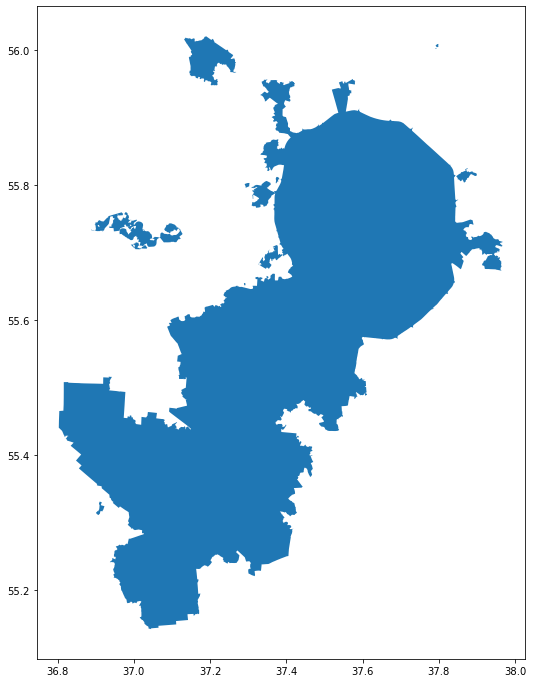

In [2]:
gdf = ox.geometries_from_place('Moscow', tags = {'boundary':'administrarive', 'admin_level':'4'}).reset_index()
gdf = gdf[(gdf['name'] == 'Москва')&(gdf['element_type'] == 'relation')].reset_index(drop = True)
gdf.plot(figsize=(12,12))

In [3]:
gdf

,element_type,osmid,note,geometry,admin_level,alt_name,contact:phone,contact:website,name,office,...,type,height,ways,addr:country,cadaster:code,gost_7.67-2003,int_ref,name:zh-Hant,ssrf:code,name:zh-Hans
0,relation,102269,NaN,"MULTIPOLYGON (((36.90075 55.31486, 36.90128 55...",4,NaN,NaN,NaN,Москва,NaN,...,boundary,NaN,"[508171529, 124033235, 508033634, 123959233, 1...",RU,NaN,РОФ-МОС,RU-MOW,莫斯科,77,莫斯科


Далее загружаю адреса и координаты магазинов с их айди, преобразую координаты в *shapely* точки.

In [4]:
st = gpd.read_file('Moscow_budgets/msc_stores.csv', encoding = 'utf-8').drop(['field_1'], axis = 1)
st[['coordinate_lat', 'coordinate_lon']] = st[['coordinate_lat', 'coordinate_lon']].astype('float')
for index, row in st.iterrows():
    st.loc[index, 'geometry'] = Point(row['coordinate_lon'], row['coordinate_lat'])
st.head()

,store_id,coordinate_lon,coordinate_lat,address_txt,geometry
0,J094,37.715630,55.760380,"111020, москва г, авиамоторная ул, 15",POINT (37.71563 55.76038)
1,D213,37.446221,55.676454,"119361, москва г, очаковская б. ул, дом 42",POINT (37.44622 55.67645)
2,5190,37.354398,55.639980,"119634, москва г, боровское ш., дом 36",POINT (37.35440 55.63998)
3,E030,37.854758,55.686435,"109156, москва г, авиаконструктора миля ул, дом 7",POINT (37.85476 55.68644)
4,X119,37.498398,55.740662,"москва г, кастанаевская ул, 6",POINT (37.49840 55.74066)


In [5]:
st.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   store_id        1227 non-null   object  
 1   coordinate_lon  1227 non-null   float64 
 2   coordinate_lat  1227 non-null   float64 
 3   address_txt     1227 non-null   object  
 4   geometry        1227 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 48.1+ KB


In [6]:
st.crs = gdf.crs

Отдельным датафреймом загружаю индексы по сегментам клиентов. Индекс в данном случае это отношение доли трат этого сегмента клиентов в данном магазине к доли трат этого сегмента в среднем по Москве. То есть индекс показывает насколько данный магазин популярен у этого сегмента. В большистве индексы лежали в промежутке от 0.5 до 2.5, редкие значения выбивающиеся за эти границы были приведены, для удобства отрисовки шкалы, к граничным значениям.

In [7]:
segments = pd.read_csv('Moscow_budgets/segment_index.csv', index_col = [0])
segments.head()

,store_id,Сегмент 1,Сегмент 2,Сегмент 3,Сегмент 4,Сегмент 5
0,300R,0.847696,0.925100,0.911428,0.775158,1.364854
1,300Z,0.543201,0.689187,0.982623,1.277400,1.625539
2,302H,1.177937,0.864484,1.035518,0.786251,1.120162
3,303E,0.950951,0.846129,1.068212,0.892189,0.993511
4,304M,0.844173,0.701877,1.185187,0.923205,1.317906


In [8]:
segments = segments.merge(st, on = 'store_id')[segments.columns]
st = st.merge(segments, on = 'store_id')[st.columns]

## 2. Построение зон для магазинов <a id='part_2'></a>

Начнем с постройки полигонов Вороного для каждого магазина. Для этой задачи использовалась библиотека `geovoronoi` (https://github.com/WZBSocialScienceCenter/geovoronoi). На вход функции требуется множество точек для которых будут строиться полигоны, а также область в пределах которой они будут построены. Сразу выведу миниатюру того как это выглядит без дальнейшей обработки

D:\Program Files\anaconda3\envs\ox\lib\site-packages\geovoronoi\_voronoi.py:202: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  geom_polys, geom_pts = region_polygons_from_voronoi(vor, geom, return_point_assignments=True, **kwargs)
D:\Program Files\anaconda3\envs\ox\lib\site-packages\geovoronoi\_voronoi.py:443: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  inner_regions_poly = cascaded_union([region_polys[i_reg] for i_reg in inner_regions])
D:\Program Files\anaconda3\envs\ox\lib\site-packages\geovoronoi\_voronoi.py:450: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  union_other_regions = cascaded_union(other_regions_polys)
D:\Program Files\anaconda3\envs\ox\lib\site-packages\geovoronoi\_voronoi.py:492: ShapelyDeprecationWarning: The 'cascaded_union()' function is depre

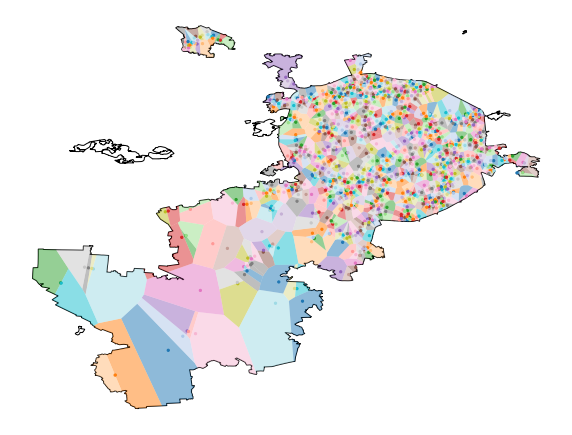

In [9]:
moscow_area = gdf.iloc[0].geometry

region_polys, region_pts = voronoi_regions_from_coords(st['geometry'], moscow_area)

fig, ax = subplot_for_map(figsize = (10,10))
plot_voronoi_polys_with_points_in_area(ax, moscow_area, region_polys, st['geometry'], region_pts)
plt.show()

На окраинах много магазинов, но в отдаленных районах на каждый магазин приходится огромная зона влияния. Заказчиком было поставлено ограничение, что как правило в магазин ходят клиенты из зоны радиусом 500 м. Ограничу каждый полигон таким радиусом. Для этого сначала построю вокруг каждого магазина буферную зону в 500 м. Для удобства построения переведу в *epsg:32637* и после построения буфера обратно в *epsg:4326*.

In [10]:
st1 = st[['store_id', 'geometry']]
st_buffer = st1.copy().to_crs(epsg=32637)
st_buffer['geometry'] = st_buffer.geometry.buffer(500).to_crs(epsg=4326)
st_buffer = st_buffer.set_index('store_id')

Чтобы было удобнее пересекать два вида полигонов определю у каждого полигона Вороного магазин для которого он построен.

In [11]:
voronoi_poly = gpd.GeoDataFrame()
voronoi_poly['geometry'] = None
for key, value in region_polys.items():
    voronoi_poly.at[key, 'geometry'] = value 
voronoi_poly.crs = st1.crs   

voronoi_poly = voronoi_poly.sjoin(st1, how ='inner')[['store_id', 'geometry']]
                           
voronoi_poly = voronoi_poly.sort_values(by = 'store_id').set_index('store_id')

Теперь пройдусь по каждому магазину и оставлю только пересечение ячейки Вороного и буфера в 500м. Для этого буду использовать функцию `overlay` из библиотеки `geopandas`. При использовании параметра *how* в значении *intersection* она оставляет только пересечения полигонов. Для удобства напишу функцию, преобразующую GeoSeries в GeoDataFrame `gs_to_gdf`. 

In [12]:
def gs_to_gdf(gs, name):
    """
    Преобразование строки %name% из GeoDataFrame в отдельный GeoDataFrame
    """
    gdf = gpd.GeoDataFrame(gs.loc[name])
    gdf.columns = ['geometry']
    gdf.index = [name]
    gdf.crs = gs.crs
    return gdf

In [13]:
pls = gpd.GeoDataFrame()
pls['geometry'] = None

for name in voronoi_poly.index:
    d = gpd.overlay(gs_to_gdf(voronoi_poly, name), gs_to_gdf(st_buffer, name), how='intersection')
    d.index = [name]
    pls = pd.concat([pls, d])
type(pls)

pls.crs = st1.crs

В результате выполнения этого цикла я отсек от буферных зон в том числе части которые не пересекаются с буферными зонами других магазинов, но пересекаются с полигонами Вороного. Чтобы уменьшить этот эффект следующим шагом я снова пройдусь по буферным зонам всех магазинов и оставлю от них те части, которые не пересекаются с полученными на прошлом шаге зонами остальных магазинов. Из-за того что в данной операции цикл проходит по очереди а не строит сразу для всех, то могут быть некоторые неоднородности на границах части магазинов, но значительная часть площади для каждого магазина будет определена верно. 

Также в результате вычитания могут получаться мультиполигоны, но я буду оставлять только основной из набора чтобы маленькие не мешали строить потом области для остальных магазинов. Напишу для этого небольшую функцию.

In [14]:
def max_polygon(mpolygon):
    """
    Выделение наибольшего полигона из мультиполигона
    """
    area = 0
    for i in range(len(mpolygon['geometry'].geoms)):
        if area < mpolygon.geometry.geoms[i].area:
            k = i
            area = mpolygon.geometry.geoms[i].area
    return mpolygon.geometry.geoms[k]

In [15]:
polys = gpd.GeoDataFrame()
polys['geometry'] = None
polys.crs = st1.crs

for name in pls.index:
    d = gpd.overlay(gs_to_gdf(st_buffer, name), pls.drop(name), how = 'difference', keep_geom_type = True)
    d.crs = st1.crs
    d = gpd.overlay(d, polys, how = 'difference', keep_geom_type = True)
    if type(d.loc[0].geometry) == type(MultiPolygon()):
        d.at[0, 'geometry'] = max_polygon(d.loc[0])
    polys = pd.concat([polys, d])

polys.crs = st1.crs

Для получившихся полигонов можно определить магазин, так же как я это делал для ячеек Вороного.

In [16]:
polys = gpd.overlay(polys, gdf, how='intersection', keep_geom_type = True)
polys = polys.sjoin(st1, how ='inner')[['store_id', 'geometry']].sort_values(by = 'store_id')
polys = polys.set_index('store_id')

Теперь подготовлю цветовую шкалу для закрашивания полигонов. Индекс > 1 - хорошо для каждого сегмента, мы его будем обозначать оттенками синего, чем насыщеннее - тем выше индекс. Индексы < 1 будут идти от желтого к красному, чем ближе к красному тем хуже. В середине будет сине-голубоватый нейтральный цвет. Для создания шкалы использую `colormap` из библиотеки `branca`.

In [17]:
colormap = cmp.LinearColormap(colors=['#a50026','#fdba6c', '#fdfdc1', '#e8f5e8', '#a3cceb', '#5f94c4', '#313695'], 
                              index=[0.50, 0.63, 0.86, 1.00, 1.50, 2.00, 2.50],
                              vmin=0.5, vmax=2.5,
                              caption = 'Индекс относительно среднего по Москве')
colormap

Строить интерактивную карту буду с помощью библиотеки `folium`. Полигоны для каждого сегмента заведу отдельными слоями, а также создам слой с маркерами для каждого магазина. При нажатии на маркер появляется всплывающее окно, в которое была выведена основная информация о работе магазина (в данном примере заменено на адрес магазина). 

Создам функцию `add_column_to_map`, которая преобразует значения в колонке в оттенки полигона и добавляет их на карту отдельным слоем.

In [18]:
# Оставляю только инфо о тех магазинах, для которых отрисовались полигоны. 
# Таких на 2 меньше чем осталось магазинов в пределах Москвы
segments = segments.set_index('store_id')
segments = segments.join(polys, how = 'inner')[segments.columns]

In [19]:
json1 = polys.to_json()

def add_column_to_map(df, name):
    """
    Преобразует значения элементов столбца в цвет полигона 
    и добавляет их на карту
    """
    statement = df[name]

    folium.GeoJson(
        json1,
        name = name,
        show = False,
        style_function=lambda feature: {
            'fillColor': colormap(statement[feature['id']]), #цвет заполнения
            'color': 'black',                                #цвет границ между полигонами
            "fillOpacity": 0.7,                              #прозрачность заполнения
            'weight': 0.5,                                   #толщина границ
        }
    ).add_to(m)

In [24]:
m = folium.Map(location=[55.753605, 37.619773], zoom_start=10, control_scale=True)

for n in segments.columns:
    add_column_to_map(segments, n)
    
mags_group = folium.map.FeatureGroup(name='Магазины', show = False)

for i in range(len(st)):
    mags_group.add_child(folium.Marker(
        location = [st.loc[i, 'geometry'].y, st.loc[i, 'geometry'].x],
        popup    = st.loc[i, 'address_txt'], show = False,
        icon     = folium.Icon(color="red", icon="info-sign"),
    ))
m.add_child(mags_group)
    
colormap.add_to(m)   #Добавление тепловой карты на схему
    
folium.LayerControl(position = 'bottomright').add_to(m) #Добавление управления слоями

## 3. Результат <a id='part_3'></a>

В результате получена карта представленная ниже, которая была сохранена как отдельный .html файл и передана заказчику. На карте, с помощью панели в нижнем правом углу, можно включать слой для каждого сегмента и смотреть в каких районах тот или иной сегмент представлен больше. Также выведены маркерами самы магазины и можно было более подробно изучить информацию о каждом из них при необходимости. Этот слой тяжеловатый, поэтому его стоит включать только на большом приближении иначе карта немного подвисает.

In [25]:
outfp = "Moscow_stores.html"
m.save(outfp)

Из дальнейших улучшений карты - хочу усовершенствовать построение буферных зон, поскольку в некоторых местах из-за очередности остаются зоны не самых ближайших магазинов

**UPD** Поскольку Gitub не поддерживает отрисовку больших файлов я добавил несколько скриншотов в качестве примеров результата. При желании можно скачать html карту из репозитория и изучить её подробнее. 

![title](map1.jpg)

![title](map15.jpg)

![title](map2.jpg)